In [186]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.layers import Conv2D, Activation, Input, Flatten, Dense, LeakyReLU
from os.path import join
from deepsky.gan import unscale_multivariate_data, rescale_data
import keras.backend as K
from deepsky.kriging import random_field_generator

In [147]:
def rescale_multivariate_data(data, scaling_values=None):
    """
    Converts raw data into normalized values for each channel and then rescales the values from -1 to 1.

    Args:
        data: ndarray of shape (examples, y, x, variable)

    Returns:
        Normalized data, values used for scaling
    """
    normed_data = np.zeros(data.shape[:-1], dtype=np.float32)
    scaled_data = np.zeros(data.shape, dtype=np.float32)
    scale_cols = ["mean", "std", "min", "max", "max_mag"]
    set_scale = False
    if scaling_values is None:
        scaling_values = pd.DataFrame(np.zeros((data.shape[-1], len(scale_cols)), dtype=np.float32),
                                      columns=scale_cols)
        set_scale = True
    for i in range(data.shape[-1]):
        if set_scale:
            scaling_values.loc[i, ["mean", "std"]] = [data[:, :, :, i].mean(), data[:, :, :, i].std()]
        normed_data[:] = (data[:, :, :, i] - scaling_values.loc[i, "mean"]) / scaling_values.loc[i, "std"]
        if set_scale:
            scaling_values.loc[i, ["min", "max"]] = [normed_data.min(), normed_data.max()]
            scaling_values.loc[i, "max_mag"] = np.max(np.abs(scaling_values.loc[i, ["min", "max"]]))
        scaled_data[:, :, :, i] = rescale_data(normed_data,
                                               -scaling_values.loc[i, "max_mag"],
                                               scaling_values.loc[i, "max_mag"])
    return scaled_data, scaling_values

In [2]:
gan_path = "/scratch/dgagne/random_gan_20170801/"
gan_params = pd.read_csv(join(gan_path, "gan_param_combos.csv"), index_col="Index")

In [5]:
gan_params.loc[1407]

activation                 leaky
batch_size                   256
beta_one                     0.5
data_width                    32
dropout_alpha                  0
filter_width                   5
generator_input_size          16
learning_rate             0.0001
length_scale              full;3
min_conv_filters              64
min_data_width                 4
seed                    14268489
train_size                131072
Name: 1407, dtype: object

In [112]:
gan_index = 1407
epoch = 10
gan_gen = load_model(join(gan_path, "gan_generator_{0:04d}_epoch_{1:04d}.h5".format(gan_index, epoch)))
gan_enc = load_model(join(gan_path, "gan_encoder_{0:04d}_epoch_{1:04d}.h5".format(gan_index, epoch)))

scaling_values = pd.read_csv(join(gan_path, "scaling_values_{0:04d}.csv".format(gan_index)))

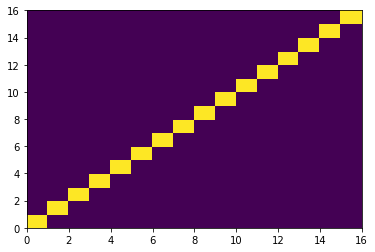

In [11]:
plt.pcolor(np.identity(16))

In [50]:
gan_diag_preds = unscale_multivariate_data(gan_gen.predict(2 * np.identity(16)), scaling_values)

In [5]:
gan_rand_preds = unscale_multivariate_data(gan_gen.predict(np.random.normal(size=(16, 16))), scaling_values)

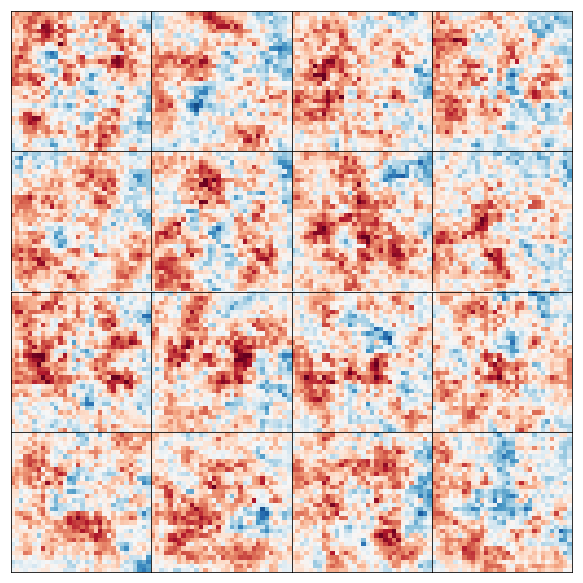

In [51]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
plt.subplots_adjust(0.02, 0.02, 0.8, 0.8, wspace=0, hspace=0)
axef = axes.ravel()
for a, ax in enumerate(axef):
    ax.pcolormesh(gan_diag_preds[a, :, :, 0], vmin=-3, vmax=3, cmap="RdBu_r")
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])

In [41]:
gan_gen.layers

In [47]:
layer = gan_gen.layers[8]
get_activations = K.function([gan_gen.layers[0].input, K.learning_phase()], [layer.output,])
activations = get_activations([2 * np.identity(16), 0])[0]

In [36]:
def make_act_quilt(activations, ex):
    row = 0
    col = 0
    dim = int(np.sqrt(np.prod(activations.shape[1:])))
    width = activations.shape[1]
    act_quilt = np.zeros((dim, dim))
    for i in range(activations.shape[-1]):
        act_quilt[row:row+width, col:col+width] = activations[ex, :, :, i]
        if row < dim - width:
            row += width
        else:
            row = 0
            col += width
    return act_quilt
                  


In [32]:
act_quilt

array([[-0.03492292, -0.01734546, -0.01591329, ..., -0.0168224 ,
        -0.01606885, -0.0094415 ],
       [-0.00709019, -0.00990508, -0.01510969, ..., -0.01003858,
        -0.00277421, -0.01548788],
       [-0.00814182, -0.01293612, -0.00496435, ..., -0.00516959,
        -0.00715745, -0.01283018],
       ..., 
       [-0.00573373, -0.01342765, -0.01075676, ...,  0.0124332 ,
        -0.00300382, -0.0122514 ],
       [-0.01531009, -0.01363903, -0.01338373, ..., -0.01706735,
         0.00151476, -0.00050488],
       [-0.00192325, -0.01298147, -0.00163521, ..., -0.01773006,
        -0.01704599, -0.02076046]])

In [48]:
for i in range(16):
    act_quilt = make_act_quilt(activations, i)
    dim = int(np.sqrt(np.prod(activations.shape[1:])))
    width = activations.shape[1]
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(act_quilt, cmap="RdBu", vmin=-0.5, vmax=0.5)
    plt.xticks(np.arange(0, dim + width, width))
    plt.yticks(np.arange(0, dim + width, width))
    plt.grid()
    plt.title("Second Convolution Layer Activations Input 1 at Position {0:d}".format(i))
    plt.savefig("all_twos/conv_act_layer_2_ex_{0:02d}.png".format(i), dpi=300, bbox_inches="tight")
    plt.close()

In [9]:
dense_weights = gan_gen.layers[1].get_weights()

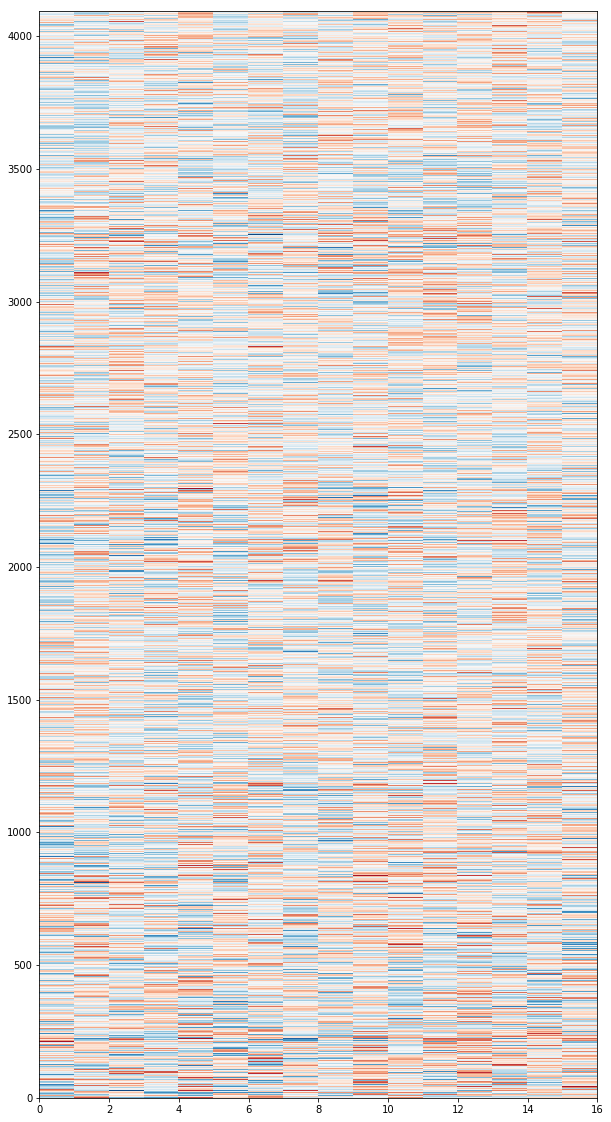

In [76]:
ext = np.max(np.abs(dense_weights[0]))
plt.figure(figsize=(10, 20))
plt.pcolormesh(dense_weights[0].T, vmin=-ext, vmax=ext, cmap="RdBu_r")

In [ ]:
plt.boxplot(dense_weights[0].T)

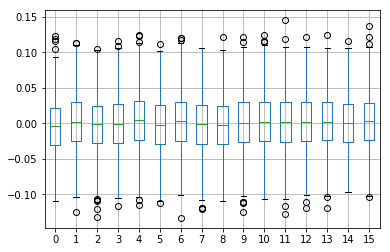

In [11]:
pd.DataFrame(dense_weights[0].T).boxplot()

In [56]:
conv_weights = gan_gen.layers[7].get_weights()[0]
conv_quilt = np.zeros((5 * 128, 5 * 64))
row = 0
col = 0
for fil in range(128):
    for lev in range(64):
        conv_quilt[fil * 5: fil * 5 + 5, lev * 5: lev * 5 + 5] = conv_weights[:, :, lev, fil]

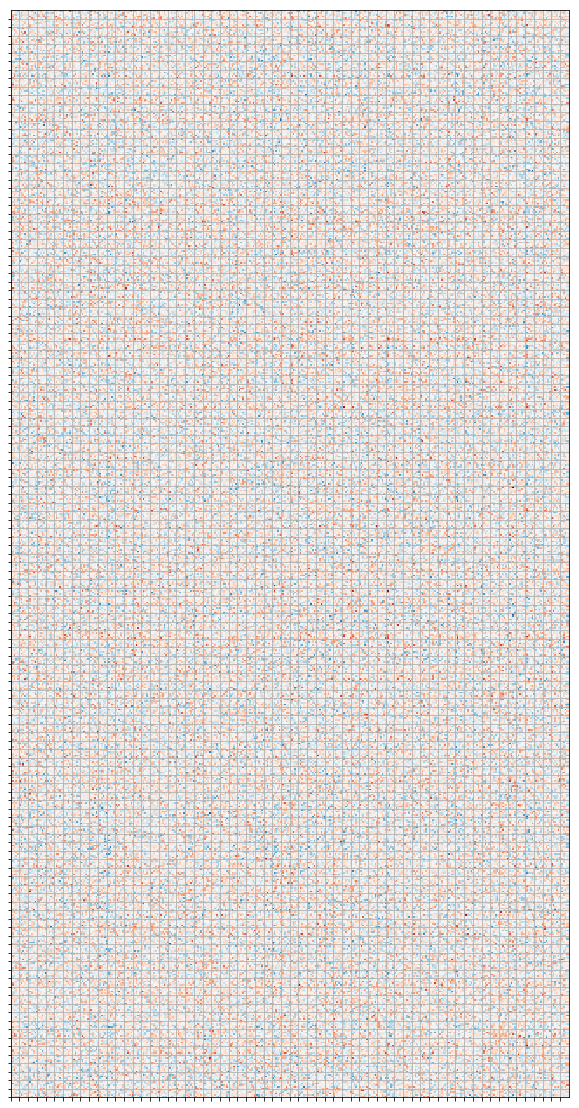

In [76]:
fig, ax = plt.subplots(figsize=(10, 20))
plt.pcolormesh(conv_quilt, vmin=-0.14, vmax=0.14, cmap="RdBu_r")
plt.xticks(np.arange(0, 64 * 5, 5), np.arange(64))
plt.yticks(np.arange(0, 128 * 5, 5), np.arange(128))
plt.grid()
ax.set_xticklabels([])
ax.set_yticklabels([])
#ax.set_xticks([])
#ax.set_yticks([])
plt.savefig("gen_conv_filters_set_2.png", dpi=400, bbox_inches="tight")

In [72]:
conv_quilt.max()

0.13600747287273407

In [84]:
conv_weights_final = gan_gen.layers[10].get_weights()[0]
conv_quilt_final = np.zeros((5 * 8, 5 * 8))
row = 0
col = 0
for fil in range(64):
    conv_quilt_final[row * 5: row * 5 + 5, col * 5: col * 5 + 5] = conv_weights[:, :, 0, fil]
    if row < 7:
        row += 1
    else:
        row = 0
        col += 1

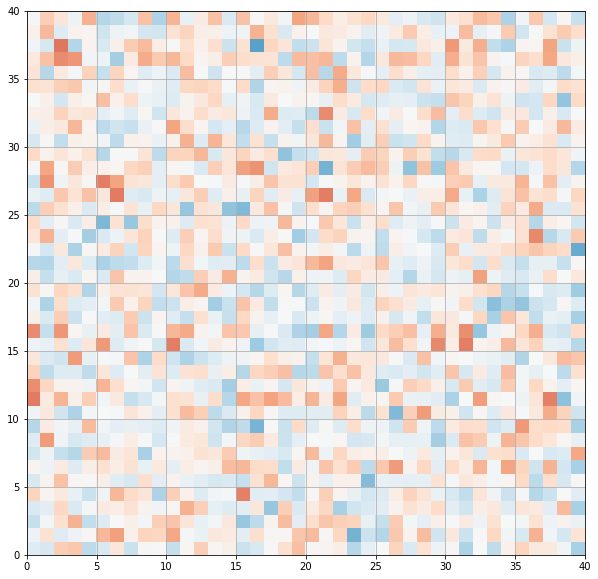

In [88]:
plt.figure(figsize=(10, 10))
plt.pcolormesh(conv_quilt_final, vmin=-0.15, vmax=0.15, cmap="RdBu_r")
plt.grid()

In [109]:
reg_vecs = np.tile(np.linspace(-3, 3, 25), 16).reshape(16, 25).T
reg_vecs

array([[-3.  , -3.  , -3.  , -3.  , -3.  , -3.  , -3.  , -3.  , -3.  ,
        -3.  , -3.  , -3.  , -3.  , -3.  , -3.  , -3.  ],
       [-2.75, -2.75, -2.75, -2.75, -2.75, -2.75, -2.75, -2.75, -2.75,
        -2.75, -2.75, -2.75, -2.75, -2.75, -2.75, -2.75],
       [-2.5 , -2.5 , -2.5 , -2.5 , -2.5 , -2.5 , -2.5 , -2.5 , -2.5 ,
        -2.5 , -2.5 , -2.5 , -2.5 , -2.5 , -2.5 , -2.5 ],
       [-2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25,
        -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25],
       [-2.  , -2.  , -2.  , -2.  , -2.  , -2.  , -2.  , -2.  , -2.  ,
        -2.  , -2.  , -2.  , -2.  , -2.  , -2.  , -2.  ],
       [-1.75, -1.75, -1.75, -1.75, -1.75, -1.75, -1.75, -1.75, -1.75,
        -1.75, -1.75, -1.75, -1.75, -1.75, -1.75, -1.75],
       [-1.5 , -1.5 , -1.5 , -1.5 , -1.5 , -1.5 , -1.5 , -1.5 , -1.5 ,
        -1.5 , -1.5 , -1.5 , -1.5 , -1.5 , -1.5 , -1.5 ],
       [-1.25, -1.25, -1.25, -1.25, -1.25, -1.25, -1.25, -1.25, -1.25,
        -1.25, -1.25, -1.2

In [110]:
reg_out = unscale_multivariate_data(gan_gen.predict(reg_vecs), scaling_values)

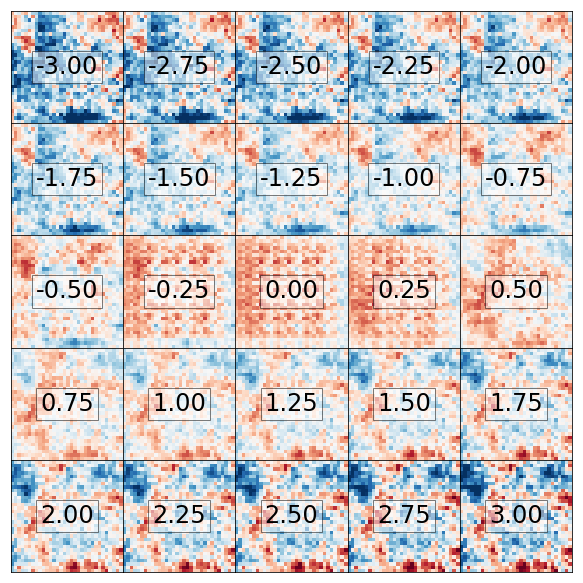

In [111]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
plt.subplots_adjust(0.02, 0.02, 0.8, 0.8, wspace=0, hspace=0)
axef = axes.ravel()
for a, ax in enumerate(axef):
    ax.pcolormesh(reg_out[a, :, :, 0], vmin=-4, vmax=4, cmap="RdBu_r")
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.text(16, 16, "{0:1.2f}".format(reg_vecs[a, 0]), fontsize=24, color="k", ha="center", va="center", bbox=dict(facecolor='w', alpha=0.5))

In [134]:
enc_out = gan_enc.predict(gan_gen.predict(3 * np.identity(16)))

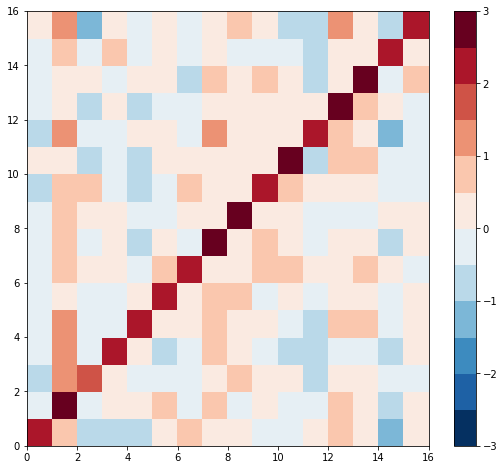

In [135]:
plt.figure(figsize=(9,8))
plt.pcolormesh(enc_out, vmin=-3, vmax=3, cmap=plt.get_cmap("RdBu_r", 12))
plt.colorbar()

In [142]:
x = np.arange(32)
y = np.arange(32)
x_g, y_g = np.meshgrid(x, y)
field_gen = random_field_generator(x_g, y_g, [3])

In [150]:
out_field = np.stack([next(field_gen) for i in range(2)], axis=0)

In [155]:
scaled_out_field, _ = rescale_multivariate_data(out_field, scaling_values=scaling_values)

In [157]:
gan_out_field = unscale_multivariate_data(gan_gen.predict(gan_enc.predict(scaled_out_field)), scaling_values)

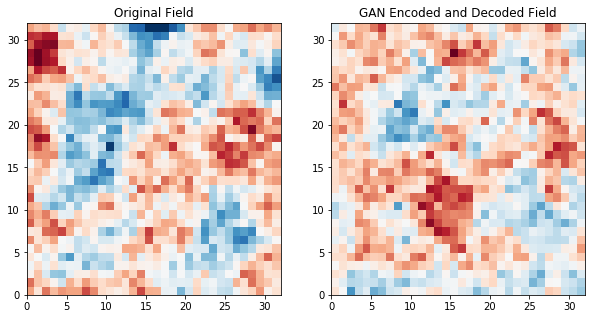

In [166]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Field")
plt.pcolormesh(out_field[1, :, :, 0], vmin=-3, vmax=3, cmap="RdBu_r")
plt.subplot(1,2,2)
plt.title("GAN Encoded and Decoded Field")
plt.pcolormesh(gan_out_field[1, :, :, 0], vmin=-3, vmax=3, cmap="RdBu_r")

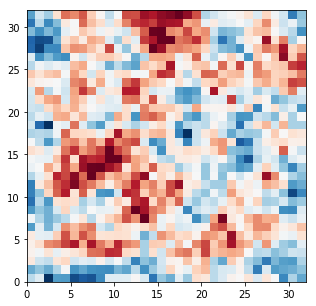

In [170]:
plt.figure(figsize=(5,5))
plt.pcolormesh(gan_out_field[1, :, :, 0] - out_field[1, :, :, 0], vmin=-3, vmax=3, cmap="RdBu_r")

In [179]:
def encoder_model(input_size=(32, 32, 1), filter_width=5, min_data_width=4,
                    min_conv_filters=64, output_size=100, stride=2):
    """
    Creates an encoder convolutional neural network that reproduces the generator input vector. The keyword arguments
    allow aspects of the structure of the generator to be tuned for optimal performance.

    Args:
        input_size (tuple of ints): Number of nodes in the input layer.
        filter_width (int): Width of each convolutional filter
        min_data_width (int): Width of the last convolved layer
        min_conv_filters (int): Number of convolutional filters in the first convolutional layer
        output_size (int): Dimensions of the output
        stride (int): Number of pixels that the convolution filter shifts between operations.

    Returns:
        Keras convolutional neural network.
    """
    num_layers = int(np.log2(input_size[0]) - np.log2(min_data_width))
    curr_conv_filters = min_conv_filters
    image_input = Input(shape=input_size, name="enc_input")
    model = None
    for c in range(num_layers):
        if c == 0:
            model = Conv2D(curr_conv_filters, filter_width,
                           strides=(stride, stride), padding="same")(image_input)
        else:
            model = Conv2D(curr_conv_filters, filter_width,
                           strides=(stride, stride), padding="same")(model)
        model = LeakyReLU(0.2)(model)
        curr_conv_filters *= 2
    model = Flatten()(model)
    model = Dense(int(curr_conv_filters / 2 * filter_width ** 2))(model)
    model = LeakyReLU(0.2)(model)
    model = Dense(output_size)(model)
    model = Activation("linear")(model)
    return model, image_input

In [275]:
enc_ind, enc_ind_input = encoder_model(min_conv_filters=64, output_size=16)

In [183]:
z_set = np.random.normal(size=(100000, 16))
gen_set = gan_gen.predict(z_set)

In [276]:
enc_ind_model = Model(enc_ind_input, enc_ind)
enc_ind_model.compile(optimizer=Adam(lr=0.0001, beta_1=0.5), loss="mse")

In [277]:
enc_hist = enc_ind_model.fit(gen_set, z_set, epochs=5, verbose=2)

Epoch 1/5
136s - loss: 0.0115
Epoch 2/5
136s - loss: 0.0019
Epoch 3/5
136s - loss: 0.0014
Epoch 4/5
136s - loss: 0.0012
Epoch 5/5
136s - loss: 0.0010


In [286]:
enc_hist.history

{'loss': [0.011536780834868551,
  0.0018603245214372872,
  0.0014229877404682337,
  0.0011752586500905454,
  0.0010152293824218213]}

In [265]:
enc_ind_preds = enc_ind_model.predict(gan_gen.predict(0.25 * np.identity(16)))

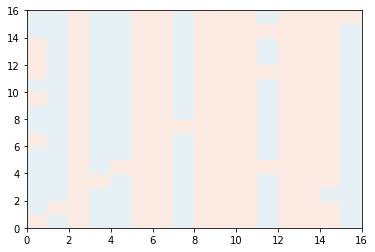

In [266]:
plt.pcolormesh(enc_ind_preds, vmin=-3, vmax=3, cmap=plt.get_cmap("RdBu_r", 12))

In [271]:
enc_ind_model.predict(scaled_out_field).min()

-0.57845962

In [272]:
gan_out_field = unscale_multivariate_data(gan_gen.predict( 2 * enc_ind_model.predict(scaled_out_field)), scaling_values=scaling_values)

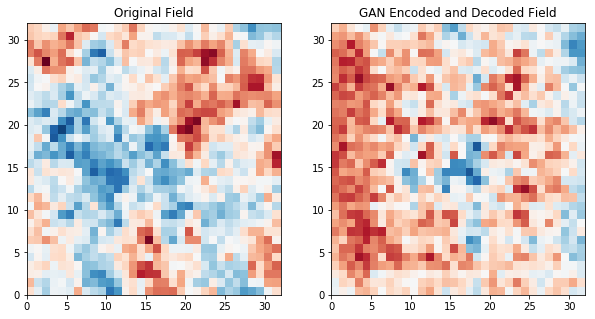

In [273]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Field")
plt.pcolormesh(out_field[0, :, :, 0], vmin=-3, vmax=3, cmap="RdBu_r")
plt.subplot(1,2,2)
plt.title("GAN Encoded and Decoded Field")
plt.pcolormesh(gan_out_field[0, :, :, 0], vmin=-3, vmax=3, cmap="RdBu_r")

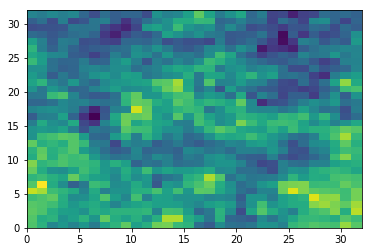

In [207]:
plt.pcolormesh(gen_set[0, :, :, 0])

In [211]:
enc_ind_model.predict(scaled_out_field)

array([[ 0.24051331, -0.09344392, -0.29170632,  0.30186611,  0.20525427,
         0.15129527, -0.05155474,  0.14478277,  0.08919808,  0.07507072,
        -0.14786465, -0.04031833, -0.10711144, -0.19314244, -0.05588777,
         0.36943614],
       [ 0.09648807, -0.57845962, -0.26116195,  0.15342794, -0.25621656,
        -0.28293467,  0.23192574,  0.14761218,  0.076246  ,  0.06090791,
         0.4934777 ,  0.21556266,  0.0384023 , -0.41467991, -0.27613437,
         0.19959784]], dtype=float32)

In [245]:
enc_ind_model.predict(scaled_out_field)

array([[ 0.24051331, -0.09344392, -0.29170632,  0.30186611,  0.20525427,
         0.15129527, -0.05155474,  0.14478277,  0.08919808,  0.07507072,
        -0.14786465, -0.04031833, -0.10711144, -0.19314244, -0.05588777,
         0.36943614],
       [ 0.09648807, -0.57845962, -0.26116195,  0.15342794, -0.25621656,
        -0.28293467,  0.23192574,  0.14761218,  0.076246  ,  0.06090791,
         0.4934777 ,  0.21556266,  0.0384023 , -0.41467991, -0.27613437,
         0.19959784]], dtype=float32)